# Example Burgers' equation

In this notebook we provide a simple example of the DeepMoD algorithm by applying it on the Burgers' equation. 

We start by importing the required libraries and setting the plotting style:

In [11]:
# General imports
import numpy as np
import torch
import matplotlib.pylab as plt
# DeepMoD stuff
from deepymod_torch.DeepMod import DeepMod
from deepymod_torch.library_functions import library_1D_in
from deepymod_torch.training import train_deepmod, train_mse

# Settings for reproducibility
np.random.seed(42)
torch.manual_seed(0)


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Next, we prepare the dataset.

In [12]:
data = np.load('data/burgers.npy', allow_pickle=True).item()
print('Shape of grid:', data['x'].shape)

Shape of grid: (256, 101)


Let's plot it to get an idea of the data:

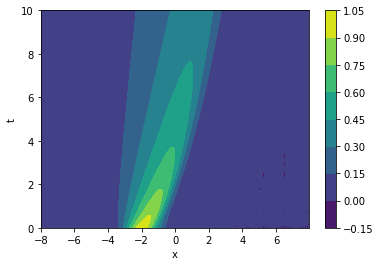

In [13]:
fig, ax = plt.subplots()
im = ax.contourf(data['x'], data['t'], np.real(data['u']))
ax.set_xlabel('x')
ax.set_ylabel('t')
fig.colorbar(mappable=im)

plt.show()

In [14]:
X = np.transpose((data['t'].flatten(), data['x'].flatten()))
y = np.real(data['u']).reshape((data['u'].size, 1))
print(X.shape, y.shape)

(25856, 2) (25856, 1)


As we can see, $X$ has 2 dimensions, $\{x, t\}$, while $y$ has only one, $\{u\}$. Always explicity set the shape (i.e. $N\times 1$, not $N$) or you'll get errors. This dataset is noiseless, so let's add $5\%$ noise:

In [15]:
noise_level = 0.05
y_noisy = y + noise_level * np.std(y) * np.random.randn(y[:,0].size, 1)

The dataset is also much larger than needed, so let's hussle it and pick out a 1000 samples:

In [16]:
number_of_samples = 1000

idx = np.random.permutation(y.shape[0])
X_train = torch.tensor(X[idx, :][:number_of_samples], dtype=torch.float32, requires_grad=True)
y_train = torch.tensor(y_noisy[idx, :][:number_of_samples], dtype=torch.float32)

In [17]:
print(X_train.shape, y_train.shape)

torch.Size([1000, 2]) torch.Size([1000, 1])


We now have a dataset which we can use. Let's plot, for a final time, the original dataset, the noisy set and the samples points:

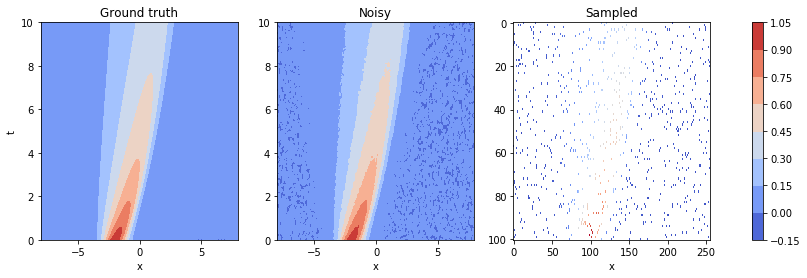

In [18]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 4))

im0 = axes[0].contourf(data['x'], data['t'], np.real(data['u']), cmap='coolwarm')
axes[0].set_xlabel('x')
axes[0].set_ylabel('t')
axes[0].set_title('Ground truth')

im1 = axes[1].contourf(data['x'], data['t'], y_noisy.reshape(data['x'].shape), cmap='coolwarm')
axes[1].set_xlabel('x')
axes[1].set_title('Noisy')

sampled = np.array([y_noisy[index, 0] if index in idx[:number_of_samples] else np.nan for index in np.arange(data['x'].size)])
sampled = np.rot90(sampled.reshape(data['x'].shape)) #array needs to be rotated because of imshow

im2 = axes[2].imshow(sampled, aspect='auto', cmap='coolwarm')
axes[2].set_xlabel('x')
axes[2].set_title('Sampled')

fig.colorbar(im1, ax=axes.ravel().tolist())

plt.show()

## Configuring DeepMoD

We now setup the options for DeepMoD. The setup requires the dimensions of the neural network, a library function and some args for the library function:

In [19]:
## Running DeepMoD
config = {'n_in': 2, 'hidden_dims': [20, 20, 20, 20, 20, 20], 'n_out': 1, 'library_function': library_1D_in, 'library_args':{'poly_order': 1, 'diff_order': 2}}

Now we instantiate the model:

In [20]:
model = DeepMod(**config)
optimizer = torch.optim.Adam([{'params': model.network_parameters(), 'lr':0.001}, {'params': model.coeff_vector(), 'lr':0.005}])

## Run DeepMoD 

We can now run DeepMoD using all the options we have set and the training data. We need to slightly preprocess the input data for the derivatives:

In [21]:
train_deepmod(model, X_train, y_train, optimizer, 25000, {'l1': 1e-5})

| Iteration | Progress | Time remaining |     Cost |      MSE |      Reg |       L1 |
        100      0.40%             371s   2.29e-02   1.64e-02   6.41e-03   1.25e-04 

KeyboardInterrupt: 

Now that DeepMoD has converged, it has found the following numbers:

In [36]:
print(model.fit.sparsity_mask)

[tensor([2, 4])]


In [38]:
print(model.fit.coeff_vector[0])

Parameter containing:
tensor([[ 0.0974],
        [-0.9905]], requires_grad=True)
